<a href="https://colab.research.google.com/github/dsevero/dsevero.com/blob/master/notebooks/On_Distributed_Quantization_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolz import pipe

colors_hex = ['#FF0000', '#0000FF']
cm_bright = ListedColormap(colors_hex)

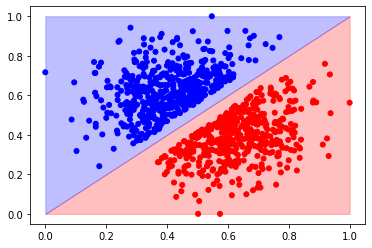

In [2]:
def normalize(X):
    x = X - X.min(axis=0)
    return x/x.max(axis=0)

def generate_data(N, separation=.25):
    X = np.random.normal(size=(N, 2))
    y = (X[:, 0] < X[:, 1]).astype(int)
    X[y == 1, 0] -= separation
    X[y == 1, 1] += separation
    X[y == 0, 0] += separation
    X[y == 0, 1] -= separation
    X = normalize(X)
    y = (X[:, 0] < X[:, 1]).astype(int)
    return X, y

def make_potential_boundaries(X):
    return pipe(X, np.ravel, np.unique, np.sort)

def plot(X, y):
    fig, ax = plt.subplots()
    ax.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(0, 1, 100)
    ax.fill_between(x, x, 0, alpha=0.25, color=colors_hex[0])
    ax.fill_between(x, x, 1, alpha=0.25, color=colors_hex[1])
    return fig, ax

X, y = generate_data(1000)
plot(X, y);

In [0]:
def _min_gap_error(X, y, si, sl=-1):
    mask = ((X > sl) & (X <= si)).all(axis=1)
    return min(((y == c) & mask).sum() for c in [0, 1])

def ontheline_quantizer(X, y, R):
    s = make_potential_boundaries(X)
    E = np.zeros((len(s), 2**R))
    
    for i, si in enumerate(s):
        E[i, 0] = _min_gap_error(X, y, si)

    return E

X, y = generate_data(50)
E = ontheline_quantizer(X, y, 3)

# Sanity checks


# # Plots
# plot(X, y);
# for b in A[-1][-1]:
#     plt.vlines(b, 0, 1, linestyles='dashed')
#     plt.hlines(b, 0, 1, linestyles='dashed')

# Sanity Checks

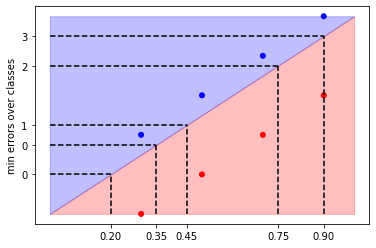

In [18]:
def test_adhoc_example():
    X = np.array([*[[0.2*i + 0.1, 0.2*(i+1)] for i in range(1, 5)],
                *[[0.2*i + 0.1, 0.2*(i-1)] for i in range(1, 5)]])
    y = (X[:, 0] < X[:, 1]).astype(int)

    plot(X, y);
    boundaries = [0.20, 0.35, 0.45, 0.75, 0.90]
    errors = [0, 0, 1, 2, 3]
    for b, e in zip(boundaries, errors):
        assert _min_gap_error(X, y, b) == e
        plt.vlines(b, 0, b, linestyles='dashed')
        plt.hlines(b, 0, b, linestyles='dashed')
        plt.xticks(boundaries)
        plt.yticks(boundaries, labels=[f'{e}' for e in errors])
        plt.ylabel('min errors over classes')

test_adhoc_example()